In [78]:
# using Pkg
# Pkg.add("https://github.com/MasanoriKanamaru/Astroshaper")
# Pkg.update("Astroshaper")

In [8]:
# Pkg.test("Astroshaper")

In [1]:
using Revise
using Astroshaper

┌ Info: Precompiling Astroshaper [ab46f4a3-3c83-4d86-98d6-41a8b1a2e76e]
└ @ Base loading.jl:1317


In [2]:
using Plots
using DataFrames
using CSV

In [3]:
using BenchmarkTools
using StaticArrays
using StructArrays
using LinearAlgebra

# 惑星の軌道要素

https://ssd.jpl.nasa.gov/?planet_pos

    OrbitalElements(a, e, I, μ) -> OrbitalElements(a, e, I, ω, Ω, Φ, tₚ, μ, n, T)

In [211]:
elms_Mercury = OrbitalElements(  0.38709843, 0.20563661,  7.00559432, GM☉ + GM_Mercury )
elms_Venus   = OrbitalElements(  0.72332102, 0.00676399,  3.39777545, GM☉ + GM_Venus   )
elms_Earth   = OrbitalElements(  1.00000018, 0.01673163, -0.00054346, GM☉ + GM_Earth   )
elms_Mars    = OrbitalElements(  1.52371243, 0.09336511,  1.85181869, GM☉ + GM_Mars    )
elms_Jupiter = OrbitalElements(  5.20248019, 0.04853590,  1.29861416, GM☉ + GM_Jupiter )
elms_Saturn  = OrbitalElements(  9.54149883, 0.05550825,  2.49424102, GM☉ + GM_Saturn  )
elms_Uranus  = OrbitalElements( 19.18797948, 0.04685740,  0.77298127, GM☉ + GM_Uranus  )
elms_Neptune = OrbitalElements( 30.06952752, 0.00895439,  1.77005520, GM☉ + GM_Neptune )
elms_Pluto   = OrbitalElements( 39.48686035, 0.24885238, 17.14104260, GM☉ + GM_Pluto   );

In [212]:
GM_Ryugu = 30.0
M_Ryugu = GM_Ryugu / G
elms_Ryugu = OrbitalElements(1.18956373, 0.19027921, 5.8840222, GM☉ + GM_Ryugu);

    addParticle!(ps, elms, m, R)

In [213]:
ps = setParticles(HermiteParticle(zeros(3), zeros(3), M☉, 6.9634e8))

addParticle!( ps, elms_Mercury, M_Mercury, 2.4394e6    )
addParticle!( ps, elms_Venus,   M_Venus,   6.0518e6    )
addParticle!( ps, elms_Earth,   M_Earth,   6.3710084e6 )
addParticle!( ps, elms_Mars,    M_Mars,    3.38950e6   )
addParticle!( ps, elms_Jupiter, M_Jupiter, 6.9911e7    )
addParticle!( ps, elms_Saturn,  M_Saturn,  5.8232e7    )
addParticle!( ps, elms_Uranus,  M_Uranus,  2.5362e7    )
addParticle!( ps, elms_Neptune, M_Neptune, 2.4622e7    )
addParticle!( ps, elms_Pluto,   M_Pluto,   1.1883e6    )

addParticle!(ps, elms_Ryugu, GM_Ryugu/G, 448.1);

In [214]:
# xs = [r[1] for r in ps.r] / AU
# ys = [r[2] for r in ps.r] / AU
# zs = [r[3] for r in ps.r] / AU

# xylim = 6
# plot(framestyle=:box, legend=false)
# plot!(aspect_ratio=:equal)
# plot!(xlims=(-xylim, xylim))
# plot!(ylims=(-xylim, xylim))
# scatter!(xs, ys)

# N体計算

In [215]:
params_sim = (
    ϵ = 0.,
    α = 7/6,
    η = 0.05,
    # t_end = 3600*24*365*1e3,
    t_end = (3600*24*365)*100,
    save_interval = 1e4,
)

(ϵ = 0.0, α = 1.1666666666666667, η = 0.05, t_end = 3153600000, save_interval = 10000.0)

In [216]:
@time run_Hermite4_test(ps, params_sim, "nbody_tmp.txt");

# E₀ = -1.9789354422738202e35
# E₁ = -1.9789354427138935e35
# ΔE = 2.22378792584197e-10
# Collision: (0, 0)
#   0.126716 seconds (940 allocations: 84.844 KiB)

E₀ = -1.9785289712740917e35
E₁ = -1.978528976286441e35
ΔE = 2.533371698105897e-9
Collision: (0, 0)
  1.148136 seconds (38.42 k allocations: 2.406 MiB, 3.19% compilation time)


# データの読込み

In [170]:
ts, snapshots = load_snapshot("nbody_tmp.txt");

In [171]:
# range_xy = 3

# anim = @animate for (t, ps) in zip(ts, snapshots)
#     r1 = ps[1].r
#     r2 = ps[2].r

#     plt = plot(framestyle=:box, legend=false, aspect_ratio=:equal, bg=:black,
#         title="t = $(lpad(round(t/3600/24), 5)) [day]",
#         xlims=(-range_xy, range_xy), xlabel="X [AU]",
#         ylims=(-range_xy, range_xy), ylabel="Y [AU]",
#     )
    
#     for p in ps
#         scatter!([p.r[1]/AU], [p.r[2]/AU])
#     end
# end

In [172]:
# gif(anim, "./nbody_tmp.gif", fps=10)

In [173]:
function evolution(ts, snapshots)
    
    elms_Mercury = StructArray(OrbitalElements[])
    elms_Venus   = StructArray(OrbitalElements[])
    elms_Earth   = StructArray(OrbitalElements[])
    elms_Mars    = StructArray(OrbitalElements[])
    elms_Jupiter = StructArray(OrbitalElements[])
    elms_Saturn  = StructArray(OrbitalElements[])
    elms_Uranus  = StructArray(OrbitalElements[])
    elms_Neptune = StructArray(OrbitalElements[])
    elms_Pluto   = StructArray(OrbitalElements[])
    elms_Ryugu   = StructArray(OrbitalElements[])
    
    for (t, ps) in zip(ts, snapshots)
        push!(elms_Mercury, OrbitalElements(ps[1], ps[2],  t))
        push!(elms_Venus,   OrbitalElements(ps[1], ps[3],  t))
        push!(elms_Earth,   OrbitalElements(ps[1], ps[4],  t))
        push!(elms_Mars,    OrbitalElements(ps[1], ps[5],  t))
        push!(elms_Jupiter, OrbitalElements(ps[1], ps[6],  t))
        push!(elms_Saturn,  OrbitalElements(ps[1], ps[7],  t))
        push!(elms_Uranus,  OrbitalElements(ps[1], ps[8],  t))
        push!(elms_Neptune, OrbitalElements(ps[1], ps[9],  t))
        push!(elms_Pluto,   OrbitalElements(ps[1], ps[10], t))
        push!(elms_Ryugu,   OrbitalElements(ps[1], ps[11], t))
    end
    elms_Mercury, elms_Venus, elms_Earth, elms_Mars, elms_Jupiter, elms_Saturn, elms_Uranus, elms_Neptune, elms_Pluto, elms_Ryugu
end

evolution (generic function with 1 method)

In [174]:
elms_Mercury, elms_Venus, elms_Earth, elms_Mars, elms_Jupiter, elms_Saturn, elms_Uranus, elms_Neptune, elms_Pluto, elms_Ryugu = evolution(ts, snapshots);

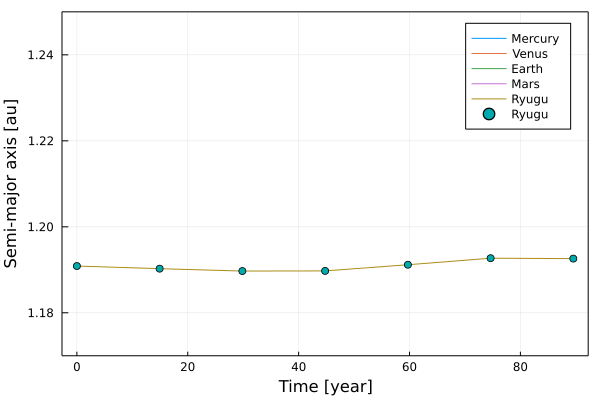

In [178]:
plot(framestyle=:box, legend=true)
plot!(xlabel="Time [year]")
plot!(ylabel="Semi-major axis [au]")
# plot!(xlims=(0, 1e6))
plot!(ylims=(1.17, 1.25))

plot!(ts/3600/24/365, elms_Mercury.a/AU, label="Mercury")
plot!(ts/3600/24/365, elms_Venus.a  /AU, label="Venus")
plot!(ts/3600/24/365, elms_Earth.a  /AU, label="Earth")
plot!(ts/3600/24/365, elms_Mars.a   /AU, label="Mars")
# plot!(times/3600/24/365, elms_Jupiter.a/AU)
# plot!(times/3600/24/365, elms_Saturn.a/AU)

plot!(ts/3600/24/365, elms_Ryugu.a/AU, label="Ryugu")
scatter!(ts/3600/24/365, elms_Ryugu.a/AU, label="Ryugu")

In [282]:
savefig("tmp_a.png")

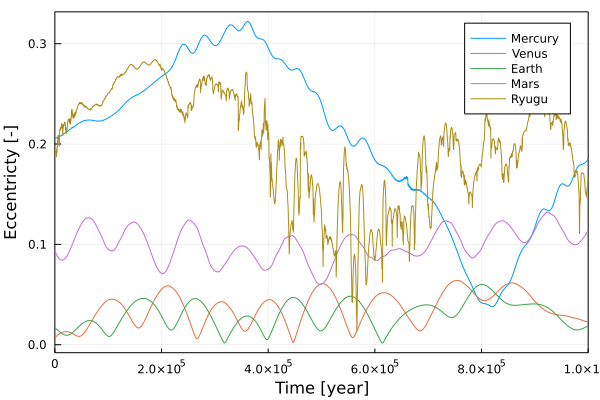

In [279]:
plot(framestyle=:box, legend=true)
plot!(xlabel="Time [year]")
plot!(ylabel="Eccentricty [-]")
plot!(xlims=(0, 1e6))
# plot!(ylims=(0.16, 0.20))

plot!(times/3600/24/365, elms_Mercury.e, label="Mercury")
plot!(times/3600/24/365, elms_Venus.e,   label="Venus")
plot!(times/3600/24/365, elms_Earth.e,   label="Earth")
plot!(times/3600/24/365, elms_Mars.e,    label="Mars")

plot!(times/3600/24/365, elms_Ryugu.e, label="Ryugu")

In [280]:
savefig("tmp.png")

In [19]:
for row in eachrow(df)
    t = row[1]
    Sun     = Particle( collect(row[ 2: 4]), collect(row[ 5: 7]), M☉,        1. )
    Mercury = Particle( collect(row[ 8:10]), collect(row[11:13]), M_Mercury, 1. )
    Venus   = Particle( collect(row[14:16]), collect(row[17:19]), M_Venus,   1. )
    Earth   = Particle( collect(row[20:22]), collect(row[23:25]), M_Earth,   1. )
    Mars    = Particle( collect(row[26:28]), collect(row[29:31]), M_Mars,    1. )
    Jupiter = Particle( collect(row[32:34]), collect(row[35:37]), M_Jupiter, 1. )
    Saturn  = Particle( collect(row[38:40]), collect(row[41:43]), M_Saturn,  1. )
    Uranus  = Particle( collect(row[44:46]), collect(row[47:49]), M_Uranus,  1. )
    Neptune = Particle( collect(row[50:52]), collect(row[53:55]), M_Neptune, 1. )
    Pluto   = Particle( collect(row[56:58]), collect(row[59:61]), M_Pluto,   1. )
    Ryugu   = Particle( collect(row[62:64]), collect(row[65:67]), M_Pluto,   1. )
    
    Astroshaper.distance(Earth, Ryugu) < 1e10Earth.R && println(t, ", ", Astroshaper.distance(Earth, Ryugu))
end

1.5842082875828016e13, 8.534042716492605e9
2.4465745888827375e13, 9.472418912290394e9


In [322]:
# xs = rs[:, 1, 2]
# ys = rs[:, 2, 2]

# plot(framestyle=:box, legend=false)
# plot!(aspect_ratio=:equal)
# plot!(xlims=(-1.2, 1.2))
# plot!(ylims=(-1.2, 1.2))
# plot!([0], [0], marker=(:plus, 5, :black))
# plot!(xs./AU, ys./AU, marker=(:circle, 1, 0.5, :blue, stroke(0, 0.2, :black, :dot)))